In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import List, Union, Any, Tuple, Dict
from sklearn.preprocessing import normalize
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *
from Bucket import *

In [2]:
data = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
def add_strategies_to_dict(data, binning_strategies:Dict, strategies:Dict, method:str, ref_bins:Dict):
    """
    """
    for key in strategies.keys():
        strategy = BucketList(bins=strategies[key], method=method, values=list(data[key].values), attribute=key, ref_bucket_list=ref_bins[key])
        #print(strategy)
        if key in binning_strategies:
            binning_strategies[key].append(strategy)
        else: binning_strategies[key] = [strategy]
    return binning_strategies

In [4]:
# Make binning strategies 
#attrs = ['Glucose', 'BMI', 'Age', 'Pregnancies', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'SkinThickness']
attrs = ['Glucose', 'BMI', 'Age']
target = 'Outcome'
gpt_glucose = BucketList(bins=[-1, 140, 200], values=data['Glucose'].values, method='gpt', attribute='Glucose')
gpt_glucose.set_KLDiv(0)
gpt_bmi = BucketList(bins=[-1, 18.5, 25, 30, 68], values=data['BMI'].values, method='gpt', attribute='BMI')
gpt_bmi.set_KLDiv(0)
gpt_age1 = BucketList(bins=[-1, 18, 35, 50, 65, 100], values=data['Age'].values, method='gpt', attribute='Age')
gpt_age1.set_KLDiv(0)
gpt_age2 = BucketList(bins=[-1, 25, 40, 55, 75, 100], values=data['Age'].values, method='gpt', attribute='Age')
binning_strategies = {
    'Glucose': [
        gpt_glucose,
        ],
    'BMI': [
        gpt_bmi,
        ],
    'Age': [
        gpt_age1, 
        ],
}
gpt_bins = {
    'Glucose': gpt_glucose,
    'BMI': gpt_bmi,
    'Age': gpt_age1, 
}

for n_bins in range(2, 10):
    df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
    # Equal width
    intervals = equal_width(df, n_bins, attrs)
    binning_strategies = add_strategies_to_dict(data, binning_strategies, intervals, 'equal_width', gpt_bins)
    #break
    # Equal frequency
    intervals = equal_frequency(df, n_bins, attrs)
    binning_strategies = add_strategies_to_dict(data, binning_strategies, intervals, 'equal_frequency', gpt_bins)
    # ChiMerge
    intervals = chimerge_wrap(df, attrs, target, n_bins)
    binning_strategies = add_strategies_to_dict(data, binning_strategies, intervals, 'chimerge', gpt_bins)
    # KMeans
    intervals = KBinsDiscretizer_wrap(df, attrs, n_bins)
    binning_strategies = add_strategies_to_dict(data, binning_strategies, intervals, 'kmeans', gpt_bins)

#print(binning_strategies)

In [19]:
df = []
for s in binning_strategies['BMI']:
    df.append([s.method, s.bins, s.KLDiv])
df = pd.DataFrame(df, columns=['method', 'bins', 'semantic'])

In [20]:
df.sort_values(by='semantic')

,method,bins,semantic
3,chimerge,"[-inf, 26.3, 67.1]",-8.793533
0,gpt,"[-1, 18.5, 25, 30, 68]",0.000000
2,equal_frequency,"[-inf, 32.0, 67.1]",0.548831
1,equal_width,"[-inf, 33.55, 67.1]",2.452606
5,equal_frequency,"[-inf, 28.9, 34.733, 67.1]",8.657319
8,equal_frequency,"[-inf, 27.3, 32.0, 36.6, 67.1]",16.112196
11,equal_frequency,"[-inf, 25.9, 30.1, 33.7, 37.8, 67.1]",20.353064
14,equal_frequency,"[-inf, 25.2, 28.9, 32.0, 34.733, 38.717, 67.1]",25.181035
4,equal_width,"[-inf, 22.367, 44.733, 67.1]",26.821259
17,equal_frequency,"[-inf, 24.7, 27.8, 30.771, 33.229, 35.7, 39.4,...",29.631178


In [6]:
strategy_combos = list(itertools.product(*binning_strategies.values()))
print("number of strategy combinations:", len(strategy_combos))

number of strategy combinations: 15625


In [22]:
print(strategy_combos[0][0])

BucketList([-1, 140, 200], [Bucket(0, 140, 576, None), Bucket(141, 200, 192, None)], gpt, 0)


In [7]:
tree_depth = 5
cols = attrs
results = []
alpha = 0.5
for strategy in strategy_combos:
    # load data
    df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
    # bin fixed columns
    df['DiabetesPedigreeFunction.binned'] = pd.cut(df['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
    df['DiabetesPedigreeFunction.binned'] = df['DiabetesPedigreeFunction.binned'].astype('float64')
    df['Pregnancies.binned'] = pd.cut(df['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
    df['Pregnancies.binned'] = df['Pregnancies.binned'].astype('int64')
    df['Insulin.binned'] = pd.cut(df['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
    df['Insulin.binned'] = df['Insulin.binned'].astype('int64')
    df['BloodPressure.binned'] = pd.cut(df['BloodPressure'], bins=[-1, 60, 90, 100, 1000], labels=[60, 90, 100, 1000])
    df['BloodPressure.binned'] = df['BloodPressure.binned'].astype('int64')
    df['SkinThickness.binned'] = pd.cut(df['SkinThickness'], bins=[-1, 20, 40, 60, 80, 100], labels=[20, 40, 60, 80, 100])
    df['SkinThickness.binned'] = df['SkinThickness.binned'].astype('int64')
    # bin variable columns
    gpt_bin_count = 0
    small_bin_count = 0
    for i in range(len(cols)):
        col = cols[i]
        bins = strategy[i]
        df[col + '.binned'] = pd.cut(df[col], bins=bins.bins, labels=bins.bins[1:])
        df[col + '.binned'] = df[col + '.binned'].astype('float64')

    # split data
    X = df[['Glucose.binned', 'Pregnancies.binned', 'Insulin.binned', 'BMI.binned', 'Age.binned',
            'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']]
    y = df['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    clf = DecisionTreeClassifier(random_state=0,max_depth=tree_depth).fit(X_train, y_train)
    try: y_pred = clf.predict(X_test)
    except: continue
    accuracy = accuracy_score(y_test, y_pred)
    s = Strategy(buckets_list=strategy, statistical_score=accuracy, alpha=alpha)
    #print("Strategy:", strategy)
    #print("Accuracy:", accuracy, "Strategy:", strategy)
    #print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    #print("Classification report:\n", classification_report(y_test, y_pred))
    row = [strategy[0], strategy[1], strategy[2], accuracy, s.semantic_score]
    results.append(row)

print("Number of results:", len(results))
results = pd.DataFrame(results, columns=['Glucose', 'BMI', 'Age', 'statistical', 'semantic'])

Number of results: 10625


In [24]:
results.head()

,Glucose,BMI,Age,statistical,semantic
0,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-1, 18, 35, 50, 65, 100], [Bucket(...",0.759740,0.000000
1,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 51. 81.], [Bucket(21, 51.0,...",0.785714,8.809880
2,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 29. 81.], [Bucket(21, 29.0,...",0.759740,3.192547
3,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 30. 81.], [Bucket(21, 30.0,...",0.740260,3.072342
4,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 41. 61. 81.], [Bucket(21, ...",0.779221,3.460049


In [8]:
# Normalize semantic score
sem_max = results['semantic'].max()
print("Semantic max:", sem_max)
print("semantic min:", results['semantic'].min())

Semantic max: 332.037482173177
semantic min: -20.08352068169061


In [9]:
alpha = 0.2
results['overall'] = results['statistical'] * (1 - alpha) + (1 / results['semantic']) * alpha
results.sort_values(by='overall', ascending=False).head(10)

,Glucose,BMI,Age,statistical,semantic,overall
0,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-1, 18, 35, 50, 65, 100], [Bucket(...",0.759740,0.000000,inf
1343,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-inf 32. 67.1], [Bucket(0, 32.0, ...",BucketList([-inf 24. 30. 42. 54. 62. 65....,0.772727,0.127110,2.191619
1344,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-inf 32. 67.1], [Bucket(0, 32.0, ...",BucketList([-inf 28.5 36. 43.5 51. 58.5 66. ...,0.753247,0.151664,1.921301
57,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-inf 32. 67.1], [Bucket(0, 32.0, ...","BucketList([-inf 36. 51. 66. 81.], [Bucket...",0.740260,0.198899,1.597742
1476,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-inf 25.9 30.1 33.7 37.8 67.1], [B...","BucketList([-inf 51. 81.], [Bucket(21, 51.0,...",0.772727,0.269544,1.360177
1380,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([ -inf 28.9 34.733 67.1 ], [Buc...","BucketList([-inf 25. 36. 81.], [Bucket(21, ...",0.772727,0.312106,1.258990
1316,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([ -inf 33.55 67.1 ], [Bucket(0, 33....",BucketList([ -inf 29.571 38.143 46.714 55.286...,0.766234,0.355574,1.175457
50,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-inf 32. 67.1], [Bucket(0, 32.0, ...","BucketList([-1, 18, 35, 50, 65, 100], [Bucket(...",0.740260,0.548831,0.956619
1312,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([ -inf 33.55 67.1 ], [Bucket(0, 33....","BucketList([-inf 24. 30. 42. 54. 81.], [B...",0.746753,0.789150,0.850840
1296,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...",BucketList([-inf 21. 24. 30. 42. 54. 62....,0.785714,1.046073,0.819763


In [11]:
results['semantic_norm'] = results['semantic'] / (results['semantic'].max() - results['semantic'].min())
alpha = 0.3
results['overall'] = results['statistical'] * (1 - alpha) - results['semantic_norm'] * alpha
results.sort_values(by='overall', ascending=False).head(10)

,Glucose,BMI,Age,statistical,semantic,overall,semantic_norm
1276,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 51. 81.], [Bucket(21, 51.0,...",0.785714,-20.083521,0.567111,-0.057036
1277,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 29. 81.], [Bucket(21, 29.0,...",0.785714,-14.466188,0.562325,-0.041083
1278,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 30. 81.], [Bucket(21, 30.0,...",0.785714,-14.345983,0.562222,-0.040742
7,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 36. 51. 66. 81.], [Bucket...",0.798701,-0.349931,0.559389,-0.000994
1281,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 24. 30. 81.], [Bucket(21, ...",0.785714,-9.777758,0.558330,-0.027768
1426,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-inf 27.3 32. 36.6 67.1], [Bucket...","BucketList([-inf 51. 81.], [Bucket(21, 51.0,...",0.792208,-3.971325,0.557929,-0.011278
1,"BucketList([-1, 140, 200], [Bucket(0, 140, 576...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 51. 81.], [Bucket(21, 51.0,...",0.785714,-8.809880,0.557506,-0.025019
1327,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-inf 32. 67.1], [Bucket(0, 32.0, ...","BucketList([-inf 29. 81.], [Bucket(21, 29.0,...",0.779221,-13.917357,0.557312,-0.039524
1291,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...",BucketList([ -inf 29.571 38.143 46.714 55.286...,0.792208,-2.097032,0.556332,-0.005955
1284,"BucketList([-inf 154. 199.], [Bucket(0, 154.0,...","BucketList([-1, 18.5, 25, 30, 68], [Bucket(0, ...","BucketList([-inf 24. 30. 54. 81.], [Bucket...",0.785714,-6.230304,0.555308,-0.017694


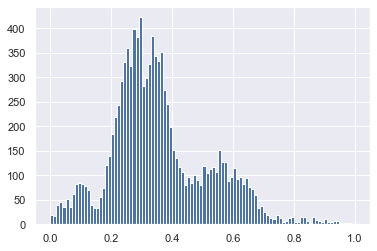

In [42]:
plt.hist(results['semantic_norm'], bins=100)
plt.show()

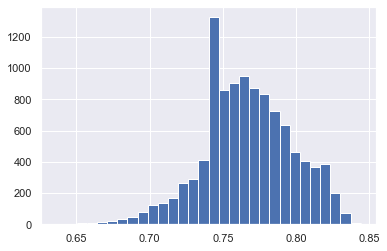

In [40]:
plt.hist(results['statistical'], bins=30)
plt.show()

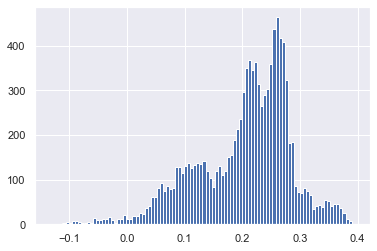

In [36]:
plt.hist(results['overall'], bins=100)
plt.show()

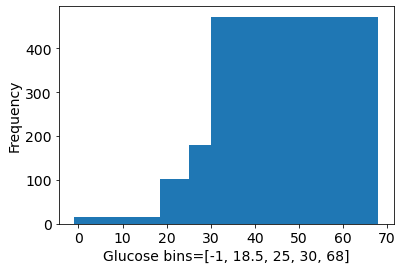

In [37]:
plt.hist(list(data['BMI'].values), bins=[-1, 18.5, 25, 30, 68])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Glucose bins=[-1, 18.5, 25, 30, 68]', size=14)
plt.ylabel('Frequency', size=14)
plt.show()

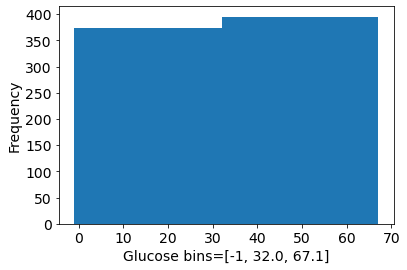

In [38]:
plt.hist(list(data['BMI'].values), bins=[-1, 32.0, 67.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Glucose bins=[-1, 32.0, 67.1]', size=14)
plt.ylabel('Frequency', size=14)
plt.show()

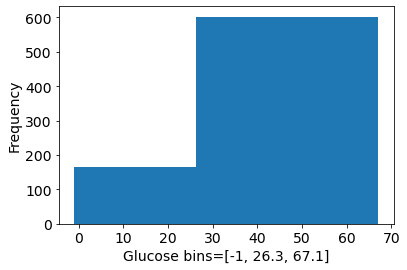

In [39]:
plt.hist(list(data['BMI'].values), bins=[-1, 26.3, 67.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Glucose bins=[-1, 26.3, 67.1]', size=14)
plt.ylabel('Frequency', size=14)
plt.show()

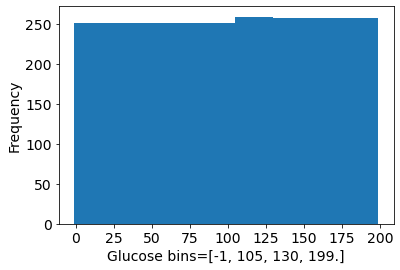

In [17]:
plt.hist(list(data['Glucose'].values), bins=[ -1,105, 130, 199. ],)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Glucose bins=[-1, 105, 130, 199.]', size=14)
plt.ylabel('Frequency', size=14)
plt.show()

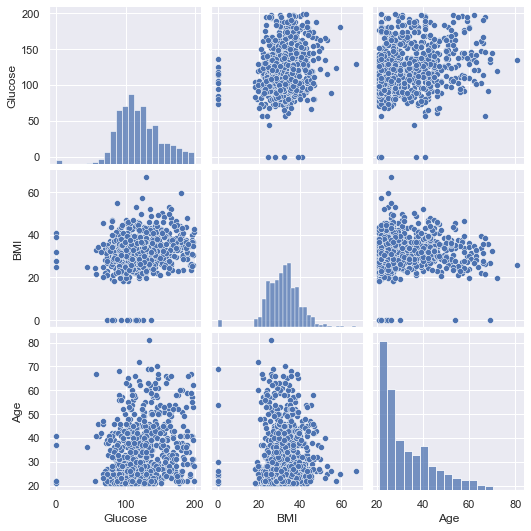

In [22]:
#scatterplot
sns.set_theme()
sns.pairplot(data[cols], size = 2.5)
plt.show()

<AxesSubplot:xlabel='BMI', ylabel='Glucose'>

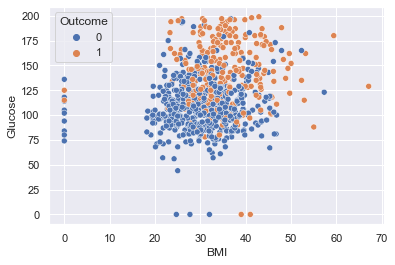

In [27]:
sns.set_theme()
sns.scatterplot(data=data, x="BMI", y="Glucose", hue="Outcome")